In [2]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [4]:
#merged_des_st82_s = fitsio.read('result_cat/merged_des_st82_nocut.fits')
path = '/n/des/lee.5922/data/gold_cat/'

columns = ['FLAGS_GOLD', 'FLAGS_BADREGION', 'MAG_MODEL_G', 'MAG_MODEL_R', 'MAG_MODEL_I', 'MAG_MODEL_Z',\
           'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_G',\
           'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z', 'MAGERR_MODEL_G', 'MAGERR_MODEL_R',\
           'MAGERR_MODEL_I', 'MAGERR_MODEL_Z', 'MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'RA',\
           'DEC', 'COADD_OBJECTS_ID', 'MODEST_CLASS', 'HPIX', 'DESDM_ZP']

merged_des_st82 = io.SearchAndCallFits(path = path, columns = columns, keyword = 'Y1A1_GOLD_STRIPE82_v2')
merged_des_st82 = merged_des_st82[merged_des_st82['MODEST_CLASS'] == 1]
#merged_des_st82 = Cuts.SpatialCuts(merged_des_st82, ra=320, ra2=360, dec=-2, dec2=2)
merged_des_st82 = Cuts.keepGoodRegion(merged_des_st82)


--------------------------------
 calling catalog
--------------------------------
Y1A1_GOLD_STRIPE82_v2_000001.fits
Y1A1_GOLD_STRIPE82_v2_000002.fits
Y1A1_GOLD_STRIPE82_v2_000003.fits
Y1A1_GOLD_STRIPE82_v2_000004.fits
Y1A1_GOLD_STRIPE82_v2_000005.fits
Y1A1_GOLD_STRIPE82_v2_000006.fits
Y1A1_GOLD_STRIPE82_v2_000007.fits
Y1A1_GOLD_STRIPE82_v2_000008.fits


In [5]:
def priorCut_test(data):
    modelmag_g_des = data['MAG_DETMODEL_G']
    modelmag_r_des = data['MAG_DETMODEL_R']
    modelmag_i_des = data['MAG_DETMODEL_I']
    cmodelmag_g_des = data['MAG_MODEL_G']
    cmodelmag_r_des = data['MAG_MODEL_R']
    cmodelmag_i_des = data['MAG_MODEL_I']
    magauto_des = data['MAG_AUTO_I']

    cut = (((cmodelmag_r_des > 17) & (cmodelmag_r_des <24)) &
           ((cmodelmag_i_des > 17) & (cmodelmag_i_des <24)) &
           ((cmodelmag_g_des > 17) & (cmodelmag_g_des <24)) &
           ((modelmag_r_des - modelmag_i_des ) < 1.5 ) & # 10122 (95%)
           ((modelmag_r_des - modelmag_i_des ) > 0. ) & # 10120 (95%)
           ((modelmag_g_des - modelmag_r_des ) > 0. ) & # 10118 (95%)
           ((modelmag_g_des - modelmag_r_des ) < 2.5 ) & # 10122 (95%)
           (magauto_des < 21. ) #&  10124 (95%)
        )
    return cut

In [6]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
#cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
print 'num of cmass in train region', cmass.size
cmass = Cuts.keepGoodRegion(cmass)
print 'num of cmass after des veto', cmass.size


--------------------------------
 calling BOSS SGC CMASS catalog
--------------------------------
Applying Healpix BOSS SGC footprint mask
Change healpix mask to spatial cut later..... Don't forget!!! 
num of cmass in train region 246982
num of cmass after des veto 11933


In [7]:
m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82['RA'], \
                                     merged_des_st82['DEC'], 2./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82[cmass_mask], merged_des_st82[~cmass_mask]
print 'num of cmass in des side', clean_cmass_data_des.size, '({:0.0f}%)'.format(clean_cmass_data_des.size*1./cmass.size * 100)

num of cmass in des side 11731 (98%)


In [8]:
mask_cmass = (clean_cmass_data_des['FLAGS_GOLD'] == 0 )&(priorCut_test(clean_cmass_data_des))
mask_all = (merged_des_st82['FLAGS_GOLD'] == 0 )&(priorCut_test(merged_des_st82))
merged_des_st82 = merged_des_st82[mask_all]
clean_cmass_data_des = clean_cmass_data_des[mask_cmass]

In [9]:
## training whole samples 

In [10]:
## partial training


# Divide sample into train and test
#(trainInd, testInd), _ = split_samples(merged_des_st82_s, merged_des_st82_s, [0.9,0.1], random_state=0)
#des_train = merged_des_st82_s[trainInd]
#des_test = merged_des_st82_s[testInd]

no_train = 0.2
#train_ind = np.random.choice( merged_des_st82.size, size = int(merged_des_st82.size * no_train))
#np.savetxt('data_txt/random_index29.txt', np.array(train_ind))
train_ind = np.array([ int(i) for i in np.loadtxt('data_txt/random_index30.txt')])
train_mask = np.zeros(merged_des_st82.size, dtype = bool)
train_mask[train_ind] = 1
des_train = merged_des_st82[train_mask]
des_test = merged_des_st82[~train_mask]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_train['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_train.size, dtype=bool)
cmass_mask[m2] = 1
cmass_train, nocmass_train = des_train[cmass_mask], des_train[~cmass_mask]

m1, m2 = esutil.numpy_util.match(clean_cmass_data_des['COADD_OBJECTS_ID'], des_test['COADD_OBJECTS_ID'])
cmass_mask = np.zeros(des_test.size, dtype=bool)
cmass_mask[m2] = 1
cmass_test, _ = des_test[cmass_mask], des_test[~cmass_mask]

print cmass_train.size, cmass_test.size, des_train.size, des_test.size

print \
clean_cmass_data_des.size * 1./merged_des_st82.size, \
cmass_train.size*1./des_train.size, \
cmass_test.size*1./des_test.size # test is always small..why?

2094 9452 128482 579946
0.0162980571067 0.0162980028331 0.0162980691306


In [11]:
# Fitting
from xd import _FindOptimalN
#n_cmass, _, _ = _FindOptimalN( np.arange(6, 30, 2), clean_cmass_data_des, pickleFileName = 'pickle/optimal_n_cmass28.pkl', suffix = '')
#n_no,_,_ = _FindOptimalN( np.arange(15,35, 2), nocmass_train, pickleFileName = 'pickle/optimal_n_no28.pkl', suffix = '')
n_all,_,_ = _FindOptimalN( np.arange(15,35, 2), des_train, pickleFileName = 'pickle/optimal_n_all30.pkl', suffix = '')
n_cmass, n_no = 6, 27
#n_all = 33

pickleFileName = 'pickle/gold_st82_30_cut21_XD_all.pkl'                  
clf_all = XD_fitting( des_train, pickleFileName = pickleFileName, \
                  init_params=None, suffix = '', n_cl = n_all )

pickleFileName = 'pickle/gold_st82_30_cut21_XD_no.pkl'                  
clf_no = XD_fitting( nocmass_train, pickleFileName = pickleFileName, \
                  init_params=None, suffix = '', n_cl = n_no )
#pickleFileName = 'pickle/gold_st82_28_cut21_XD_cmass_tot.pkl'
#clf_cmass = XD_fitting( clean_cmass_data_des, pickleFileName = pickleFileName,\
#                       suffix = '', n_cl = n_cmass )
pickleFileName = 'pickle/gold_st82_30_cut21_XD_cmass.pkl'
clf_cmass = XD_fitting( cmass_train, pickleFileName = pickleFileName,\
                       suffix = '', n_cl = n_cmass )

@pickle_results: using precomputed results from 'pickle/optimal_n_all30.pkl'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  29
@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_all.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_no.pkl'
@pickle_results: using precomputed results from 'pickle/gold_st82_30_cut21_XD_cmass.pkl'


In [15]:
cmass_fraction = cmass_train.size*1./des_train.size 
#cmass_fraction = clean_cmass_data_des.size *1./merged_des_st82_s.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
merged_des_st82_s = assignCMASSProb( merged_des_st82, clf_cmass, clf_no, cmass_fraction = cmass_fraction )
des_train = merged_des_st82_s[train_mask]
des_test = merged_des_st82_s[~train_mask]

cmass_fraction 0.0139492135964
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 


writing output plot to: figure/gold_st82_27_cut21_st82_diagnostic_histograms_1d.png


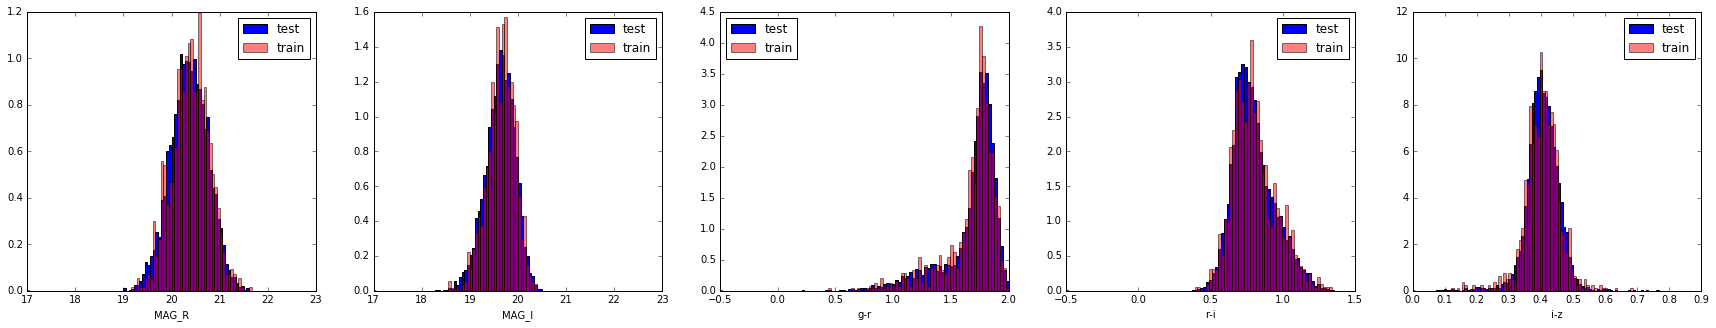

In [18]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(dmass_train, suffix ='')
X_test,_ = mixing_color(dmass_test, suffix = '')
doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='gold_st82_27_cut21_st82_')

In [19]:
def getavgbias( cat, pstart=0.0 ):
    from systematics_module.contCorrection import logL_from_mag,logL_to_galaxyBias
    mag = cat['MAG_MODEL_I']
    z = cat['DESDM_ZP']
    logL = logL_from_mag( mag = mag, z = z )
    avg_b = logL_to_galaxyBias(logL = logL)
    print 'avg bias=',avg_b, ' sample size=', mag.size
    return avg_b

In [20]:
avg_b_cmass = getavgbias( clean_cmass_data_des )
avg_b_dmass_train = getavgbias( dmass_train )
avg_b_dmass_test = getavgbias( dmass_test )
avg_b_dmass = getavgbias( dmass )

print 'bias ratio b_dmass/b_cmass, train', avg_b_dmass_train * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, test ', avg_b_dmass_test * 100/ avg_b_cmass, '%'
print 'bias ratio b_dmass/b_cmass, all  ', avg_b_dmass * 100/ avg_b_cmass, '%'

avg bias= 1.18008938782  sample size= 9966
avg bias= 1.17254104348  sample size= 963
avg bias= 1.18959077572  sample size= 9203
avg bias= 1.18278987038  sample size= 10168
bias ratio b_dmass/b_cmass, train 99.3603582558 %
bias ratio b_dmass/b_cmass, test  100.805141373 %
bias ratio b_dmass/b_cmass, all   100.228837119 %


## Calling SPT

In [86]:
path = '/n/des/lee.5922/data/gold_cat/'
des_spt = io.SearchAndCallFits(path = path, keyword = 'Y1A1_GOLD_00')
des_spt = des_spt[des_spt['MODEST_CLASS'] == 1]
des_spt = Cuts.keepGoodRegion(des_spt)
des_spt = des_spt[des_spt['DEC'] < -3]
mask_y1a1 = (des_spt['FLAGS_GOLD'] == 0 )&(priorCut_test(des_spt))
des_spt = des_spt[mask_y1a1]

Y1A1_GOLD_000002.fits
Y1A1_GOLD_000003.fits
Y1A1_GOLD_000005.fits
Y1A1_GOLD_000007.fits
Y1A1_GOLD_000009.fits
Y1A1_GOLD_000011.fits
Y1A1_GOLD_000013.fits
Y1A1_GOLD_000015.fits
Y1A1_GOLD_000001.fits
Y1A1_GOLD_000004.fits
Y1A1_GOLD_000006.fits
Y1A1_GOLD_000008.fits
Y1A1_GOLD_000010.fits
Y1A1_GOLD_000012.fits
Y1A1_GOLD_000014.fits


In [95]:
row = np.random.choice(des_spt.size, size = int(des_spt.size * 0.01))
des_spt = des_spt[row]

In [27]:
# Fitting
from xd import _FindOptimalN
n_spt,_,_ = _FindOptimalN( np.arange(15,35, 2), nocmass_train, pickleFileName = 'pickle/optimal_n_spt.pkl', suffix = '')

pickleFileName = 'pickle/gold_st82_cut21_XD_spt.pkl'                  
clf_spt = XD_fitting( nocmass_train, pickleFileName = pickleFileName, \
                  init_params=None, suffix = '', n_cl = n_spt )

@pickle_results: using precomputed results from 'pickle/optimal_n_spt.pkl'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  29
@pickle_results: using precomputed results from 'pickle/gold_st82_cut21_XD_spt.pkl'


In [71]:
sample_spt = clf_spt.sample(200000)
sample = clf_all.sample(200000)
sample_no = clf_no.sample(200000)

writing output plot to: figure/deconvdiagnostic_histograms_1d.png
writing output plot to: figure/deconv_sptdiagnostic_histograms_1d.png
writing output plot to: figure/deconv_sptdiagnostic_histograms_1d.png


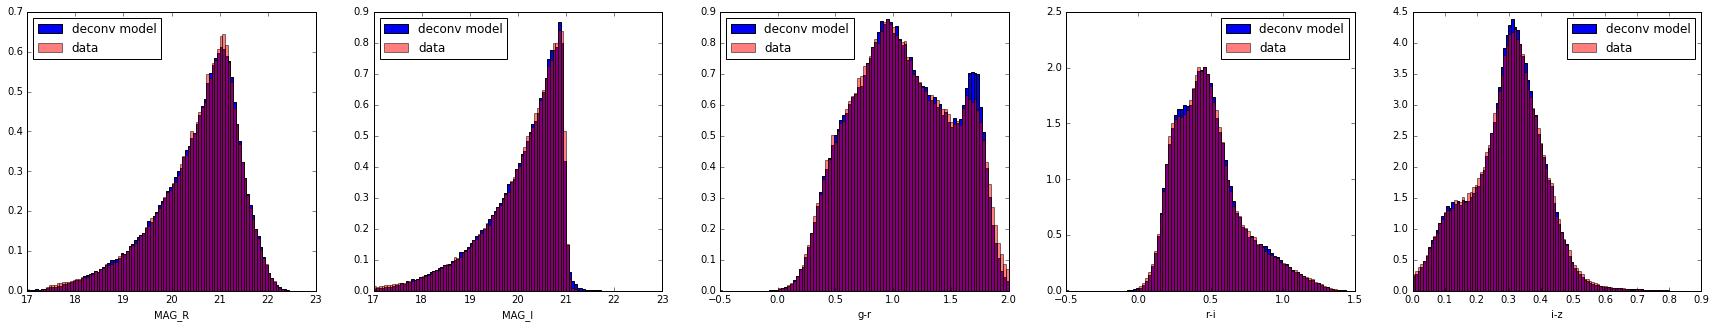

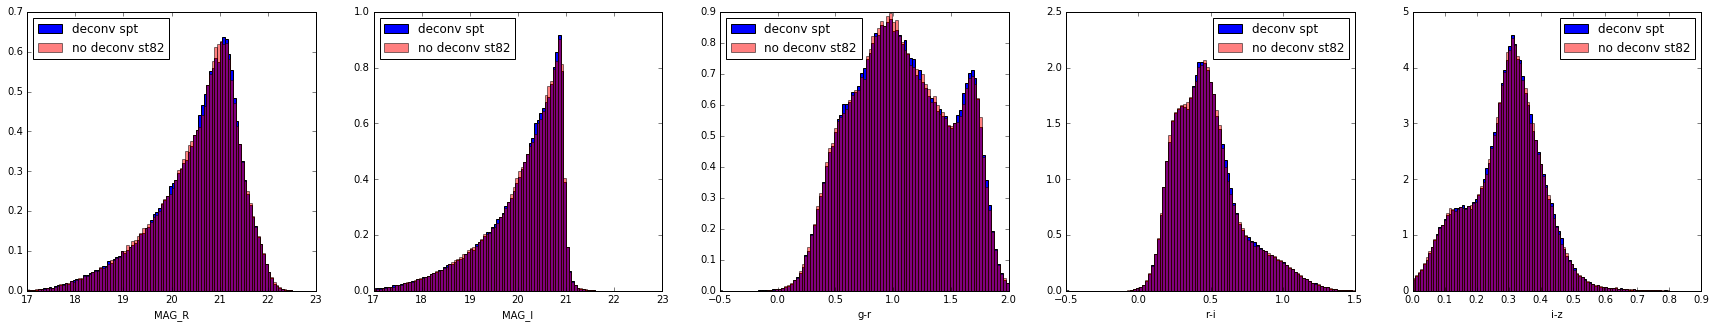

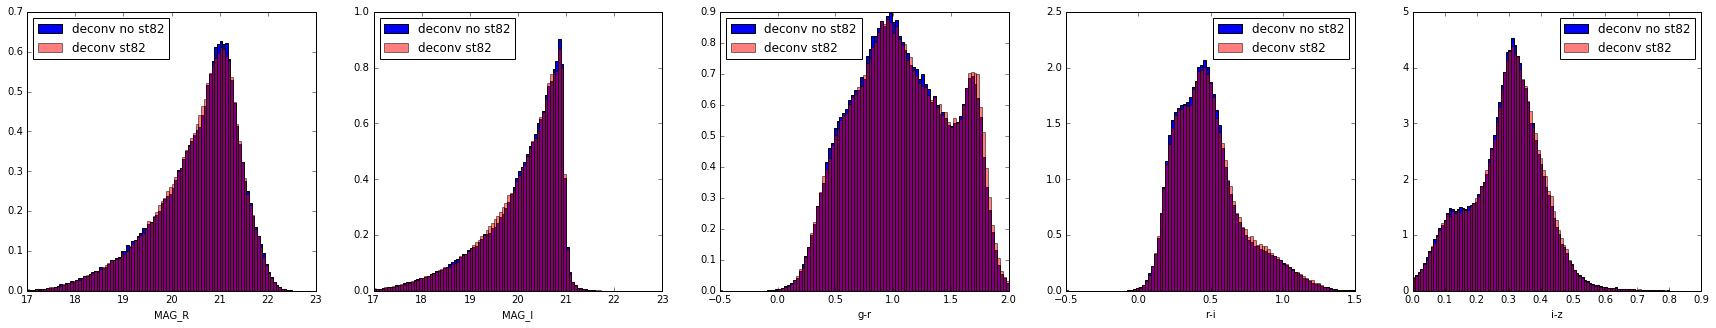

In [93]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]

X_train, Xcov_train = mixing_color(des_train, suffix ='')
doVisualization_1d( X_train, sample, labels = labels, ranges = ranges,\
                         name =['data','deconv model' ], nbins=100, prefix='deconv')

doVisualization_1d( sample_no, sample_spt, labels = labels, ranges = ranges,\
                         name =['no deconv st82','deconv spt' ], nbins=100, prefix='deconv_spt')

doVisualization_1d( sample, sample_no, labels = labels, ranges = ranges,\
                         name =['deconv st82','deconv no st82' ], nbins=100, prefix='deconv_spt')

In [96]:
# dmass from spt
cmass_fraction = cmass_train.size*1./des_train.size 

rabin = np.linspace(des_spt['RA'].min(), des_spt['RA'].max(), 15)
ind_map = np.digitize(des_spt['RA'], bins = rabin)

des_spt_list = []
for i in range(1, rabin.size):
    ts = assignCMASSProb(des_spt[ind_map == i] , clf_cmass, clf_spt, cmass_fraction = cmass_fraction )
    des_spt_list.append(ts)
    ts = None
des_spt = np.hstack(des_spt_list)
des_spt_list = None

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing

In [97]:
dmass_spt, _ = resampleWithPth( des_spt, pstart = 0, pmax = 1.0 )

In [100]:
clean_cmass_data_des.size, dmass_spt.size

(11546, 1094)

writing output plot to: figure/clf_sptdiagnostic_histograms_1d.png


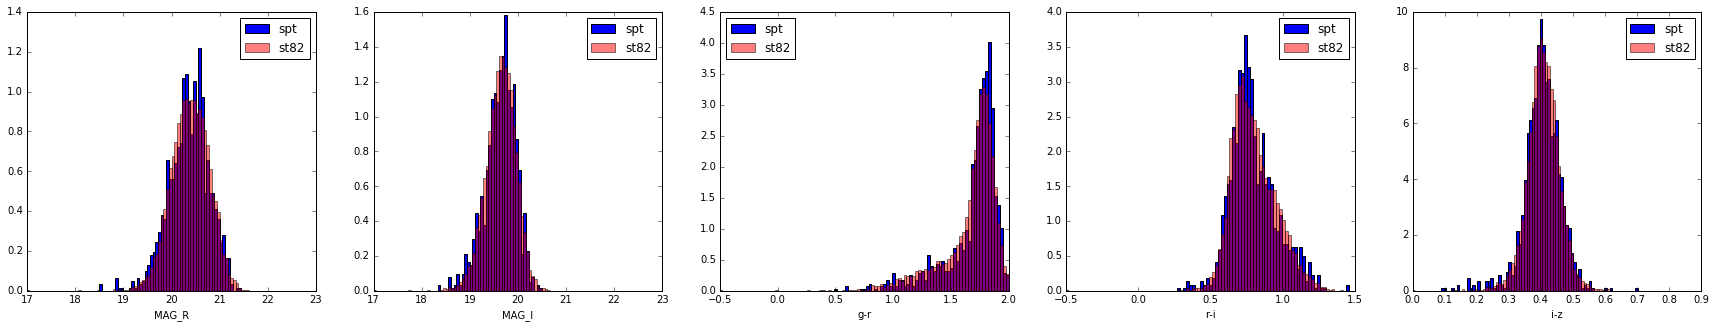

In [102]:
X_train, Xcov_train = mixing_color(clean_cmass_data_des, suffix ='')
X_test, _ = mixing_color(dmass_spt, suffix ='')
doVisualization_1d(X_train, X_test, labels = labels, ranges = ranges,\
                         name =['st82','spt' ], nbins=100, prefix='clf_spt')